In [103]:
import pandas as pd 
import numpy as np


In [104]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [105]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [106]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(include=['int64', 'float64']).columns
print("Categorical columns:", categorical)
print("Numerical columns:", numerical)

Categorical columns: Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')
Numerical columns: Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score', 'converted'],
      dtype='object')


In [107]:
for col in categorical:
    df[col].fillna('NA', inplace=True)
for col in numerical:
    df[col].fillna(0.0, inplace=True)

df.isna().sum()

C:\Users\chwing\AppData\Local\Temp\ipykernel_1568\1501077214.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NA', inplace=True)
C:\Users\chwing\AppData\Local\Temp\ipykernel_1568\1501077214.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [108]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train)/len(df), len(df_val)/len(df), len(df_test)/len(df)

(0.5991792065663475, 0.20041039671682626, 0.20041039671682626)

In [109]:
from sklearn.metrics import roc_auc_score
features_to_check = numerical.drop('converted')
results = {}
target = 'converted'
for feature in features_to_check:
    scores = df_full_train[feature].values
    try:
        # print("try test")
        auc_val = roc_auc_score(df_full_train[target].values, scores)
        # print("try test")
    except Exception:
       # print("except test")
       auc_val = float('nan')
    if auc_val < 0.5:
        auc_val = roc_auc_score(df_train[target].values, -scores)
        direction = 'negated'
    else:
        direction = 'original'
    results[feature] = auc_val
    print(f"{feature}: AUC={auc_val:.4f} ({direction})")

best = max(results, key=results.get)
print(f"Best feature: {best} with AUC={results[best]:.4f}")

number_of_courses_viewed: AUC=0.7579 (original)
annual_income: AUC=0.5533 (original)
interaction_count: AUC=0.7277 (original)
lead_score: AUC=0.6164 (original)
Best feature: number_of_courses_viewed with AUC=0.7579


Question 2


In [113]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
train_dicts = df_full_train[categorical.tolist() + numerical.tolist()].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical.tolist() + numerical.tolist()].to_dict(orient='records')
X_val = dv.transform(val_dicts)
X_train.shape, X_val.shape

((1169, 32), (293, 32))

In [114]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_full_train[target].values)

LogisticRegression(max_iter=1000, solver='liblinear')

In [115]:
y_val = df_val[target].values
y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print("AUC (rounded to 3 digits):", round(auc, 3))

options = [0.32, 0.52, 0.72, 0.92]
closest = min(options, key=lambda x: abs(x - auc))
print("Closest option:", closest)

AUC (rounded to 3 digits): 0.874
Closest option: 0.92


Threshold: 0.00, Precision: 0.584, Recall: 1.000
Threshold: 0.01, Precision: 0.584, Recall: 1.000
Threshold: 0.02, Precision: 0.584, Recall: 1.000
Threshold: 0.03, Precision: 0.584, Recall: 1.000
Threshold: 0.04, Precision: 0.584, Recall: 1.000
Threshold: 0.05, Precision: 0.584, Recall: 1.000
Threshold: 0.06, Precision: 0.584, Recall: 1.000
Threshold: 0.07, Precision: 0.584, Recall: 1.000
Threshold: 0.08, Precision: 0.584, Recall: 1.000
Threshold: 0.09, Precision: 0.584, Recall: 1.000
Threshold: 0.10, Precision: 0.584, Recall: 1.000
Threshold: 0.11, Precision: 0.584, Recall: 1.000
Threshold: 0.12, Precision: 0.584, Recall: 1.000
Threshold: 0.13, Precision: 0.584, Recall: 1.000
Threshold: 0.14, Precision: 0.584, Recall: 1.000
Threshold: 0.15, Precision: 0.584, Recall: 1.000
Threshold: 0.16, Precision: 0.584, Recall: 1.000
Threshold: 0.17, Precision: 0.584, Recall: 1.000
Threshold: 0.18, Precision: 0.584, Recall: 1.000
Threshold: 0.19, Precision: 0.586, Recall: 1.000
Threshold: 0.20, Pre

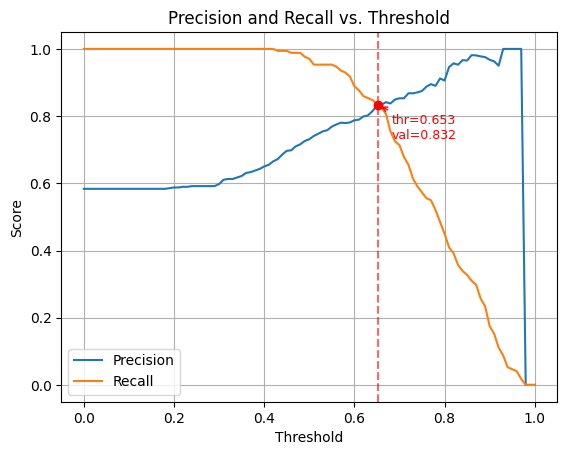

In [124]:
from matplotlib import pyplot as plt
thresholds1 = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds1:
    y_pred_label = (y_pred >= t).astype(int)
    tp = ((y_val == 1) & (y_pred_label == 1)).sum() # true positives
    fp = ((y_val == 0) & (y_pred_label == 1)).sum() # false positives
    fn = ((y_val == 1) & (y_pred_label == 0)).sum() # false negatives
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    precisions.append(precision)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    recalls.append(recall)
    print(f"Threshold: {t:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

plt.plot(thresholds1, precisions, label='Precision')
plt.plot(thresholds1, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
prec = np.array(precisions)
rec = np.array(recalls)
diff = prec - rec

# try to find a sign change for a more precise crossing via linear interpolation
ix = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]
if len(ix) > 0:
    i = ix[0]
    x0, x1 = thresholds1[i], thresholds1[i+1]
    y0, y1 = diff[i], diff[i+1]
    t_cross = x0 - y0 * (x1 - x0) / (y1 - y0)
    val_cross = prec[i] + (prec[i+1] - prec[i]) * (t_cross - x0) / (x1 - x0)
else:
    # fallback: closest point if no sign change exactly
    idx = np.argmin(np.abs(diff))
    t_cross = thresholds1[idx]
    val_cross = prec[idx]

# mark intersection on the plot
plt.scatter([t_cross], [val_cross], color='red', zorder=5)
plt.axvline(t_cross, color='red', linestyle='--', alpha=0.6)
plt.annotate(f"thr={t_cross:.3f}\nval={val_cross:.3f}",
             xy=(t_cross, val_cross),
             xytext=(t_cross + 0.03, val_cross - 0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=9,
             color='red')
plt.grid(True)
plt.show()






C:\Users\chwing\AppData\Local\Temp\ipykernel_1568\313136100.py:3: RuntimeWarning: invalid value encountered in scalar divide
  f1.append(2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]) )


nan


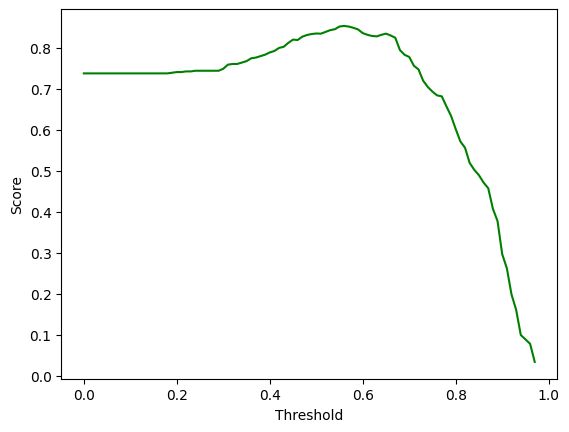

In [ ]:
f1 = []
for i in range(len(thresholds1)):
    f1.append(2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]) )
plt.plot(thresholds1, f1, label='F1 Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')


In [129]:
from sklearn.model_selection import KFold
KFold(n_splits=5, shuffle=True, random_state=1)


KFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []

for train_idx, val_idx in kf.split(df_full_train):
    train_df = df_full_train.iloc[train_idx]
    val_df = df_full_train.iloc[val_idx]

    train_dicts = train_df[categorical.tolist() + numerical.tolist()].to_dict(orient='records')
    X_tr = dv.transform(train_dicts)
    y_tr = train_df[target].values

    val_dicts = val_df[categorical.tolist() + numerical.tolist()].to_dict(orient='records')
    X_val_fold = dv.transform(val_dicts)
    y_val_fold = val_df[target].values

    clf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    clf.fit(X_tr, y_tr)

    y_pred_fold = clf.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    aucs.append(auc)

aucs = np.array(aucs)
print("AUCs per fold:", np.round(aucs, 4))
print("Mean AUC:", np.round(aucs.mean(), 4))
print("Std AUC:", np.round(aucs.std(), 4))

options = [0.0001, 0.006, 0.06, 0.36]
closest = min(options, key=lambda x: abs(x - aucs.std()))
print("Closest option for std:", closest)